# Isogeometric analysis of the Poisson equation: Non homogeneous boundary condition.

  Let $\Omega\subset\mathbb{R}^d$ be an open set with sufficiently smooth boundary, denoted by $\Gamma$, where $d=2$ is the number of spatial dimensions. Then, the problem stated in strong form as :

Find $\mathbf{c} :\overline{\Omega}\times(0,T)\longmapsto\mathbb{R}$ such that 
## $	\begin{align*}
		\left\lbrace\begin{array}{lll}
			 -\nabla \mathbf{A}(x)\cdot \nabla\mathbf{u} + \mathbf{B}\cdot\nabla\mathbf{u} + c\nabla\mathbf{u}&=~ f&\text{ in } \Omega ,~~~~~~~~~~(1)\\
		    \mathbf{u} &=~ g &\text{ on } \partial\Omega,~~~~~~~~(2)\\
		\end{array}\right.
	\end{align*}$
 Where $g\in H^{-\frac{1}{2}}(\partial\Omega)$ and $\mathbf{A}, \mathbf{B}\in \left(L^{\infty}(\Omega)\right)^2$.

## 2. Variational form and discrete formulation

Let X be the functional space and $\big(.,.\big)_\Omega$ denote the $L^2$ inner product with respect to  $\Omega$. We introduce the decomposition $\mathbf{u}= \mathbf{u}_0+\mathbf{u}_g $, where $\mathbf{u}_g\in X_g$. The variational formulation is stated as follows :

Find $\mathbf{u}_0\in X_0$, such that $\forall~w\in X_0$ : 

$$\textbf{B}\big(w,\mathbf{u}_0\big) = \mathbf{L}_g(w) ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(8)$$

with

$$\begin{align*}\textbf{B}\big(w,\mathbf{v}\big) &= \big(\nabla
w,\mathbf{A}\nabla\mathbf{v}\big)_\Omega + \big(
w,\mathbf{B}\cdot\nabla\mathbf{v}\big)_\Omega+ \big(
w,c\mathbf{v}\big)_\Omega.~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(9)\\
\textbf{L}_g\big(w\big) &= \big(w,f\big)_\Omega -\big(\nabla
w,\nabla\mathbf{u_g}\big)_\Omega - \big(
w,\mathbf{B}\cdot\nabla\mathbf{u_g}\big)_\Omega- \big(
w,c\mathbf{u_g}\big)_\Omega.~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(10)
\end{align*}$$

The space discretization of (11) leads to the following variational problem over the finite element spaces : 

Find $\mathbf{u}^h \in X^h\subset X$, such that $\forall~w^h \in X^h$ : 

$$\textbf{B}\big(w^h, \mathbf{u}^h\big) = \textbf{L}_g\big(w^h\big) ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(10)$$

where 

$$\mathbf{u}^h = \sum_{i=1}^{n_b} \mathbf{u}_iN_i, ~~~ w^h = \sum_{i=1}^{n_b} w_iN_i~~~~~~~~~~~~~~~~~~~~~~~~~~~~(11)$$

$n_b$ is the dimension of discrete space.

# 5. Numerical implementation under psydac.

In [10]:
from simplines import pyccel_sol_field_2d
#from matplotlib.pyplot import plot, show
import matplotlib.pyplot            as     plt
from   mpl_toolkits.axes_grid1      import make_axes_locatable
import numpy as np

def plot_dtres(VPh,x11, x12, xh, solution = None, nbpts=50):  
    u_h = pyccel_sol_field_2d((nbpts,nbpts), xh, VPh.knots, VPh.degree)[0]
    X   = pyccel_sol_field_2d((nbpts,nbpts),  x11 , VPh.knots, VPh.degree)[0]
    Y   = pyccel_sol_field_2d((nbpts,nbpts),  x12 , VPh.knots, VPh.degree)[0]
    # ....
    fig , axes=plt.subplots() 
    im2 = plt.contourf( X, Y, u_h, cmap= 'jet')
    divider = make_axes_locatable(axes) 
    cax   = divider.append_axes("right", size="5%", pad=0.05, aspect = 40) 
    plt.colorbar(im2, cax=cax) 
    fig.tight_layout()
    plt.savefig('sol_{}.png')
    plt.show(block=True)
    plt.close() 
    if solution is not None :
        # ....
        solution = lambda a, b : (a**2 + b**2-0.2**2)*(a**2 + b**2 - 1.) * np.sin(a)*np.sin(b)
        #np.absolute(u_h-solution(X, Y))/np.max(np.absolute(solution(X, Y)))
        fig , axes=plt.subplots() 
        im2 = plt.contourf( X, Y, np.absolute(u_h-solution(X, Y))/np.max(np.absolute(solution(X, Y))), cmap= 'jet')
        divider = make_axes_locatable(axes) 
        cax   = divider.append_axes("right", size="5%", pad=0.05, aspect = 40) 
        plt.colorbar(im2, cax=cax) 
        fig.tight_layout()
        plt.savefig('errr_inf.png')
        plt.show(block=True)
        plt.close()

In [ ]:
# 2d linear Advection diffusion equation
#
# $$
# B .\nabla( u) - \nabla. A \nabla( u) = f
# $$
from psydac.fem.splines  import SplineSpace
from sympy import sqrt, pi, cos, sin, exp, log, symbols
from sympy.utilities.lambdify import implemented_function
import pytest

from sympde.calculus import grad, dot
from sympde.calculus import laplace
from sympde.topology import ScalarFunctionSpace
from sympde.topology import element_of
from sympde.topology import NormalVector
from sympde.topology import Square
from sympde.topology import Union
from sympde.expr     import BilinearForm, LinearForm, integral
from sympde.expr     import Norm
from sympde.expr     import find, EssentialBC
from sympde.expr.expr import linearize
from sympde.core     import Constant
from psydac.api.essential_bc   import apply_essential_bc

from psydac.fem.basic          import FemField
from psydac.api.discretization import discretize
# needed imports
from numpy import zeros, ones, linspace, zeros_like, loadtxt
from matplotlib.pyplot import plot, contourf, show, colorbar
from matplotlib import pyplot as plt

from sympde.topology.derivatives import dx1, dx2
from sympy import Tuple

# ... abstract model
domain  = Square()
B_dir   = domain.boundary

V       = ScalarFunctionSpace('V', domain)

x,y     = domain.coordinates

u,v     = [element_of(V, name=i) for i in ['u', 'v']]

# ... mapping in a B-spline form
m1,m2   = [element_of(V, name=i) for i in ['m1', 'm2']]

#... Dirichlet (ud is free parameter and must be provided later)
ud      = element_of(V, name='ud')

A       = ( (2. + cos(m1))*(1. + m2), cos(m1 + m2) * sin(m1 + m2),
            cos(m1 +m2) * sin(m1 + m2), (2. + sin(m2))*(1. + m1))
A_c     = ( (2. + cos(x))*(1. + y), cos(x + y) * sin(x + y),
            cos(x +y) * sin(x + y), (2. + sin(y))*(1. + x))
# ... test 1
#B       = (11.+ sin(m1) + m2*sin(m1) - 2.*cos(m1 + m2)**2, -9. - cos(m2) + m1*cos(m2) - 2.*cos(m1 + m2)**2)
#B_c     = (11.+ sin(x) + y*sin(x) - 2.*cos(x + y)**2, -9. - cos(y) + x*cos(y) - 2.*cos(x + y)**2)
#c       = 1.

# ... test 2
B       = (-5.*m2, 5.*m1)
B_c     = (-5.*y, 5.*x)
c       = m1*m2
c_c     = x*y


#bracket = lambda a,b: dx1(a)*dx2(b) - dx2(a)*dx1(b)
dx_com  = lambda a,b, trg : (dx2(b) * dx1(trg) - dx1(b) * dx2(trg))/abs( dx1(a) * dx2(b) - dx1(b) * dx2(a))
dy_com  = lambda a,b, trg : (dx1(a) * dx2(trg) - dx2(a) * dx1(trg))/abs( dx1(a) * dx2(b) - dx1(b) * dx2(a))

bracket = lambda a,b, trg1, trg2: (A[0] * dx_com(a,b, trg1) + A[1] * dy_com(a,b, trg1) ) * dx_com(a,b, trg2) + (A[2] * dx_com(a,b, trg1) + A[3] * dy_com(a,b, trg1) ) * dy_com(a,b, trg2) + (B[0]*dx_com(a,b, trg1) + B[1]*dy_com(a,b, trg1))*trg2 + c*trg1*trg2

#.. for non symetric solution (Pc)
#solution = lambda a,b: sin(2.*pi*a)*sin(2.*pi*b)
solution = lambda a,b: (a**2 + b**2-0.2**2)*(a**2 + b**2 - 1.) * sin(a)*sin(b)
#.. for computation
# Compute the expression of the right-hand side (RHS) first, and then utilize it in subsequent functions : /!\ 
#solution_c = (x**2 + y**2 - 0.2**2)*(x**2 + y**2 - 1.) * sin(x)*sin(y)
#f          = -dx1(A_c[0]*dx1(solution_c) + A_c[1]*dx2(solution_c)) - dx2(A_c[2]*dx1(solution_c) + A_c[3]*dx2(solution_c)) + B_c[0]*dx1(solution_c) + B_c[1]*dx2(solution_c) + c_c*solution_c
#print(f)
# ...
f        = lambda x1, x2 : x1*x2*(x1**2 + x2**2 - 1.0)*(x1**2 + x2**2 - 0.04)*sin(x1)*sin(x2) + 5.0*x1*(2*x2*(x1**2 + x2**2 - 1.0)*sin(x1)*sin(x2) + 2*x2*(x1**2 + x2**2 - 0.04)*sin(x1)*sin(x2) + (x1**2 + x2**2 - 1.0)*(x1**2 + x2**2 - 0.04)*sin(x1)*cos(x2)) - 5.0*x2*(2*x1*(x1**2 + x2**2 - 1.0)*sin(x1)*sin(x2) + 2*x1*(x1**2 + x2**2 - 0.04)*sin(x1)*sin(x2) + (x1**2 + x2**2 - 1.0)*(x1**2 + x2**2 - 0.04)*sin(x2)*cos(x1)) - (x1 + 1.0)*(sin(x2) + 2.0)*(8*x2**2*sin(x1)*sin(x2) + 4*x2*(x1**2 + x2**2 - 1.0)*sin(x1)*cos(x2) + 4*x2*(x1**2 + x2**2 - 0.04)*sin(x1)*cos(x2) - (x1**2 + x2**2 - 1.0)*(x1**2 + x2**2 - 0.04)*sin(x1)*sin(x2) + (2*x1**2 + 2*x2**2 - 2.0)*sin(x1)*sin(x2) + (2*x1**2 + 2*x2**2 - 0.08)*sin(x1)*sin(x2)) - (x1 + 1.0)*(2*x2*(x1**2 + x2**2 - 1.0)*sin(x1)*sin(x2) + 2*x2*(x1**2 + x2**2 - 0.04)*sin(x1)*sin(x2) + (x1**2 + x2**2 - 1.0)*(x1**2 + x2**2 - 0.04)*sin(x1)*cos(x2))*cos(x2) - (x2 + 1.0)*(cos(x1) + 2.0)*(8*x1**2*sin(x1)*sin(x2) + 4*x1*(x1**2 + x2**2 - 1.0)*sin(x2)*cos(x1) + 4*x1*(x1**2 + x2**2 - 0.04)*sin(x2)*cos(x1) - (x1**2 + x2**2 - 1.0)*(x1**2 + x2**2 - 0.04)*sin(x1)*sin(x2) + (2*x1**2 + 2*x2**2 - 2.0)*sin(x1)*sin(x2) + (2*x1**2 + 2*x2**2 - 0.08)*sin(x1)*sin(x2)) + (x2 + 1.0)*(2*x1*(x1**2 + x2**2 - 1.0)*sin(x1)*sin(x2) + 2*x1*(x1**2 + x2**2 - 0.04)*sin(x1)*sin(x2) + (x1**2 + x2**2 - 1.0)*(x1**2 + x2**2 - 0.04)*sin(x2)*cos(x1))*sin(x1) + (2*x1*(x1**2 + x2**2 - 1.0)*sin(x1)*sin(x2) + 2*x1*(x1**2 + x2**2 - 0.04)*sin(x1)*sin(x2) + (x1**2 + x2**2 - 1.0)*(x1**2 + x2**2 - 0.04)*sin(x2)*cos(x1))*sin(x1 + x2)**2 - (2*x1*(x1**2 + x2**2 - 1.0)*sin(x1)*sin(x2) + 2*x1*(x1**2 + x2**2 - 0.04)*sin(x1)*sin(x2) + (x1**2 + x2**2 - 1.0)*(x1**2 + x2**2 - 0.04)*sin(x2)*cos(x1))*cos(x1 + x2)**2 + (2*x2*(x1**2 + x2**2 - 1.0)*sin(x1)*sin(x2) + 2*x2*(x1**2 + x2**2 - 0.04)*sin(x1)*sin(x2) + (x1**2 + x2**2 - 1.0)*(x1**2 + x2**2 - 0.04)*sin(x1)*cos(x2))*sin(x1 + x2)**2 - (2*x2*(x1**2 + x2**2 - 1.0)*sin(x1)*sin(x2) + 2*x2*(x1**2 + x2**2 - 0.04)*sin(x1)*sin(x2) + (x1**2 + x2**2 - 1.0)*(x1**2 + x2**2 - 0.04)*sin(x1)*cos(x2))*cos(x1 + x2)**2 - 2*(8*x1*x2*sin(x1)*sin(x2) + 2*x1*(x1**2 + x2**2 - 1.0)*sin(x1)*cos(x2) + 2*x1*(x1**2 + x2**2 - 0.04)*sin(x1)*cos(x2) + 2*x2*(x1**2 + x2**2 - 1.0)*sin(x2)*cos(x1) + 2*x2*(x1**2 + x2**2 - 0.04)*sin(x2)*cos(x1) + (x1**2 + x2**2 - 1.0)*(x1**2 + x2**2 - 0.04)*cos(x1)*cos(x2))*sin(x1 + x2)*cos(x1 + x2)



# ... let's start

# bilinear form
expr = bracket(m1,m2,u,v)
a    = BilinearForm((u,v), integral(domain , expr * abs( dx1(m1) * dx2(m2) - dx1(m2) * dx2(m1))))

# bilinear form for the mass matrix TODO f is not in space
expr = u*v
m    = BilinearForm((u,v), integral(domain , expr * abs( dx1(m1) * dx2(m2) - dx1(m2) * dx2(m1))))

# linear form for initial condition
expr = f(m1,m2) *v - bracket(m1,m2,ud,v)
l    = LinearForm(v, integral(domain, expr * abs( dx1(m1) * dx2(m2) - dx1(m2) * dx2(m1))) )
l_d  = LinearForm(v, integral(domain, solution(m1,m2) * v * abs( dx1(m1) * dx2(m2) - dx1(m2) * dx2(m1))) )

bc   = [EssentialBC(u,    0., domain.boundary)]
equation = find(u, forall=v, lhs=a(u, v), rhs=l(v), bc= bc)
# ## Discretization using Psydac
from psydac.api.discretization import discretize
from psydac.api.settings       import PSYDAC_BACKEND_GPYCCEL
# ..
from scipy.sparse.linalg import gmres
from simplines import plot_field_2d

degree = [2,2]     # spline degree :
ncells = [32,32]   # number of elements

# Quart_ annulus : r = 0.2 R = 1. degree 2
#name_1 = 'fields/Squarx_'  
#name_2 = 'fields/Squary_'
# Quart_ annulus : r = 0.2 R = 1. degree 2, 3, 4
name_1 = 'fields/QAx_'  
name_2 = 'fields/QAy_'
# Infinite plate with circular hole  degree = 2
#name_1 = 'fields/IPx_'  
#name_2 = 'fields/IPy_'
# CIRCLE degree 2, 3
#name_1 = 'fields/Circlex_'  
#name_2 = 'fields/Circley_'

class Adv_diffusion(object):
    
    def __init__(self, degree, ncells):

        # Create computational domain from topological domain
        domain_h = discretize(domain, ncells=ncells, comm=None)
        # Discrete spaces
        Vh       = discretize(V, domain_h, degree=degree)
        # ...
        nbasis   = [W.nbasis for W in Vh.spaces]
        
        if ncells[0] == 16 :
            xmp      = loadtxt(name_1+str(degree[0])+'_'+str(16)+'.txt')
            ymp      = loadtxt(name_2+str(degree[1])+'_'+str(16)+'.txt')
        else :
            from   simplines                    import prolongation_matrix
            # Create computational domain from topological domain
            domain_H = discretize(domain, ncells=[16,16], comm=None)
            # Discrete spaces
            VH       = discretize(V, domain_H, degree=degree)
            # ...
            xmp      = loadtxt(name_1+str(degree[0])+'_'+str(16)+'.txt')
            ymp      = loadtxt(name_2+str(degree[1])+'_'+str(16)+'.txt')
            # ...
            M_mp            = prolongation_matrix(VH, Vh)
            xmp             = (M_mp.dot(xmp.reshape((16+degree[0])*(16+degree[1])))).reshape(nbasis)
            ymp             = (M_mp.dot(ymp.reshape((16+degree[0])*(16+degree[1])))).reshape(nbasis)
        
        # ... mapping in discret space
        mh1      = FemField( Vh, Vh.vector_space.zeros() )
        mh2      = FemField( Vh, Vh.vector_space.zeros() )
        # ...
        mh1.coeffs[0:nbasis[0],0:nbasis[1]]  = xmp[:,:]
        mh2.coeffs[0:nbasis[0],0:nbasis[1]]  = ymp[:,:]
        
        # Discretize the bilinear forms
        ah       = discretize(a, domain_h, [Vh, Vh])#, backend=PSYDAC_BACKEND_GPYCCEL)
        mh       = discretize(m, domain_h, [Vh, Vh])#, backend=PSYDAC_BACKEND_GPYCCEL)

        # Discretize equation using Dirichlet bc
        equation_h = discretize(equation, domain_h, [Vh, Vh])

        # Discretize the linear form for the initial condition
        lh       = discretize(l, domain_h, Vh)#, backend=PSYDAC_BACKEND_GPYCCEL)
        lh_d     = discretize(l_d, domain_h, Vh)#, backend=PSYDAC_BACKEND_GPYCCEL)

        # Error norms
        error    = v*(u - solution(m1,m2)) * sqrt(abs( dx1(m1) * dx2(m2) - dx1(m2) * dx2(m1)))
        l2norm   = LinearForm(v, integral(domain, error) )

        # assemble matrices and convert them to scipy
        M        = mh.assemble(m1 = mh1, m2 = mh2).tosparse()
        S        = ah.assemble(m1 = mh1, m2 = mh2)
        # ...

        # L2 projection of the solution (we computes here Dirichlet boundary condition)
        # assemble the rhs and convert it to numpy array
        rhs_d          = lh_d.assemble(m1 = mh1, m2 = mh2).toarray()
        u_d, status    = gmres(M, rhs_d, tol=1.e-8, maxiter=5000)
        # ---
        u_d            = u_d.reshape(nbasis)
        u_d[1:-1,1:-1] = 0.
        udh            = FemField( Vh, Vh.vector_space.zeros() )
        udh.coeffs[0:nbasis[0],0:nbasis[1]]  = u_d[:,:]

        #plot_field_2d(Vh.knots, Vh.degree, un) ; colorbar() ; show()
        #plot_field_2d(Vh.knots, Vh.degree, un.reshape(nbasis), vmin=0., vmax=1.) ; colorbar() #; show()

        #
        rhs          = lh.assemble(ud = udh, m1 = mh1, m2 = mh2)
        apply_essential_bc(S, *equation_h.bc, identity=True)
        apply_essential_bc(rhs, *equation_h.bc)

        S            = S.tosparse()
        rhs          = rhs.toarray()
        # Discretize error norms
        l2norm_h     = discretize(l2norm, domain_h, Vh)
        # ------
        self.l2norm_h= l2norm_h
        self.Vh      = Vh 
        self.nbasis  = nbasis
        # ...
        self.S       = S
        self.rhs     = rhs
        self.M       = M
        self.u_d     = u_d
        self.udh     = udh
        self.mh1     = mh1
        self.mh2     = mh2
        self.xmp     = xmp
        self.ymp     = ymp
    def solve(self):
        Vh           = self.Vh
        S            = self.S
        rhs          = self.rhs
        nbasis       = self.nbasis
        u_d          = self.u_d
        xmp          = self.xmp
        ymp          = self.ymp
        # ...
        u_ap, status = gmres(S, rhs, tol=1.e-6, maxiter=3000)
        u_ap         = u_ap.reshape(nbasis)
        u_ap[:, :]  += u_d[:, :]

        plot_dtres(Vh, xmp, ymp, u_ap.reshape(nbasis), solution = True)
        return u_ap

    def l2_error(self, u_ap):
        Vh        = self.Vh 
        mh1       = self.mh1
        mh2       = self.mh2
        nbasis    = self.nbasis
        l2norm_h  = self.l2norm_h
        
        uh        = FemField( Vh, Vh.vector_space.zeros() )
        uh.coeffs[0:nbasis[0],0:nbasis[1]]  = u_ap[:,:]
        val_error = sqrt(sum(self.l2norm_h.assemble(u=uh, m1 = mh1, m2 = mh2).toarray()))
        print('le-error = ', val_error)
        return val_error
    
ad = Adv_diffusion(degree, ncells)

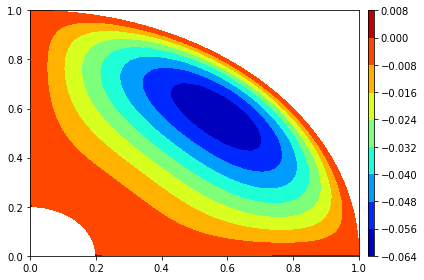

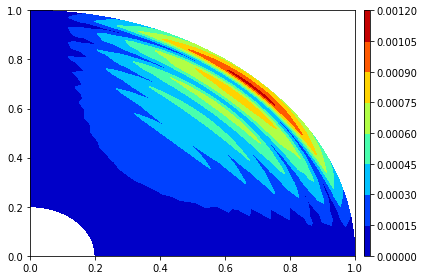

le-error =  0.00307070229441496*I


0.00307070229441496*I

In [4]:
u_ap = ad.solve()
ad.l2_error(u_ap)

## Here's another way to write the code TODO

# BAHARI Mustapha